# Value at Risk for Stock Market Trends

We import the needed Python libraries

In [1]:
import numpy
import scipy.stats
import datetime
import matplotlib.pyplot as plt
from pandas.io.data import DataReader, DataFrame
%matplotlib inline

/Users/rcuevas/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Analysis of stock market returns and volatility

We analyse the Microsoft stock market data for 2013

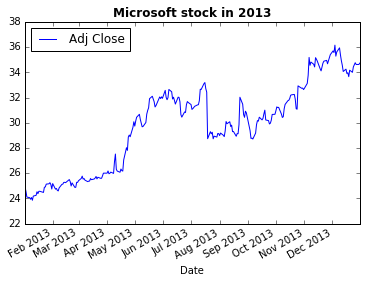

In [26]:
start = datetime.datetime(2013, 1, 1)
end   = datetime.datetime(2014, 1, 1)
MSFT = DataReader("MSFT", "yahoo", start, end)
MSFT.plot(y="Adj Close")
plt.title(u"Microsoft stock in 2013", weight='bold');

In [29]:
MSFT.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,27.250000,27.730000,27.150000,27.620001,52899300,24.891298
2013-01-03,27.629999,27.650000,27.160000,27.250000,48294400,24.557851
2013-01-04,27.270000,27.340000,26.730000,26.740000,52521100,24.098236
2013-01-07,26.770000,26.879999,26.639999,26.690001,37110400,24.053176
2013-01-08,26.750000,26.790001,26.459999,26.549999,44703100,23.927006


For risk analysis we are interested in daily changes as opposed to the absolute value of the stock. Let's then plot the daily returns on the stock.

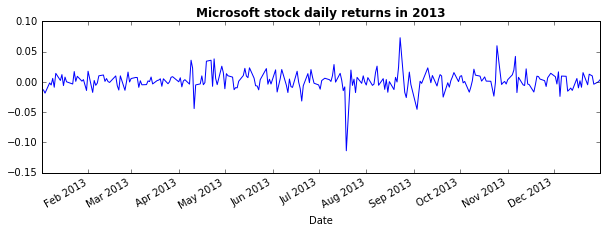

In [27]:
fig = plt.figure()
fig.set_size_inches(10,3)
MSFT["Adj Close"].pct_change().plot()
plt.title(u"Microsoft stock daily returns in 2013", weight='bold');

0.015604552504929385

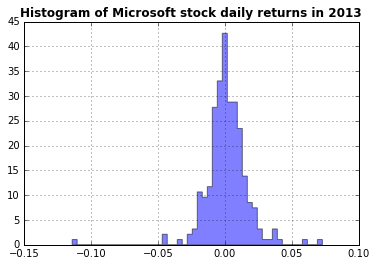

In [4]:
MSFT["Adj Close"].pct_change().hist(bins=50, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Microsoft stock daily returns in 2013", weight='bold')
MSFT["Adj Close"].pct_change().std()

We do a QQ-plot to see if the daily returs follow closer a normal distribution or a Student-t  distribution.

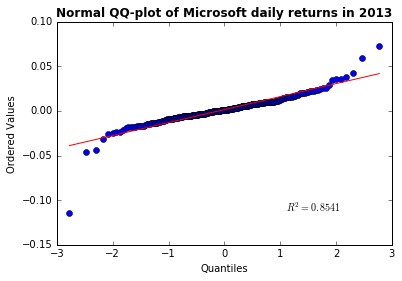

In [30]:
Q = MSFT["Adj Close"].pct_change().dropna().as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Microsoft daily returns in 2013", weight="bold");

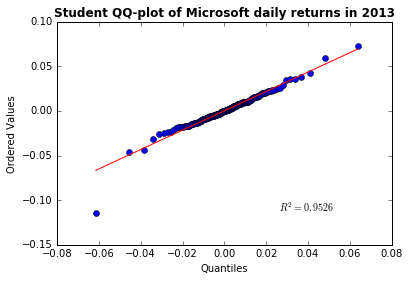

In [31]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Microsoft daily returns in 2013", weight="bold");

Data seem to fit better to a Student-t distribution

## VaR using the historical bootstrap method

We calculate **empirical quantiles** from a histogram of daily returns. Let's do that for the returns of Halliburton (stock market ticker `HAL`) over 2010--2014.

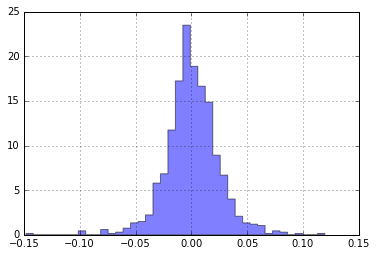

In [34]:
start = datetime.datetime(2010, 1, 1)
end   = datetime.datetime(2014, 1, 1)
stock = DataReader("HAL", "yahoo", start, end)
returns = stock["Close"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);

In [35]:
returns.quantile(0.05)

-0.034135137465728119

The 0.05 empirical quantile of daily returns is at -0.034. That means that with 95% confidence, our worst daily loss will not exceed 3.4%. If we have a 1M€ investment, our one-day 5% VaR is 0.034 * 1M€ = 34 k€.

## VaR using the variance-covariance method

We calculate analytic quantiles by curve fitting to historical data. Here, we use Student's t distribution as we checked it represents daily returns relatively well.

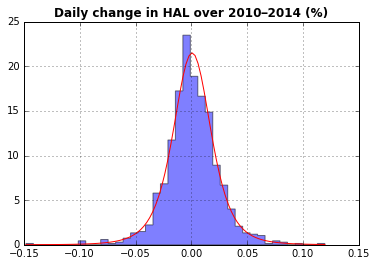

In [36]:
support = numpy.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in HAL over 2010–2014 (%)", weight='bold');

In [37]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.038383332571956787

Our analytic 0.05 quantile is at -0.0384, so with 95% confidence, our worst daily loss will not exceed 3.84%. For a 1M€ investment, one-day Value at Risk is 0.0384 * 1M€ = 38k€.

# VaR using Monte Carlo method

We run many trials with random market conditions, calculating portfolio loss for each trial. Use the aggregated trial data to establish a profile of the porfolio's risk characteristics. See the slides associated with this notebook for details.

**Hypothesis**: stock market evolution can be simulated by geometric Brownian motion (this is a rough hypothesis; see the literature on stochastic methods in finance for more sophisticated, and more realistic, models, such as jump diffusion).


We set some parameters of the geometric Brownian motion.

In [38]:
days = 300   # time horizon
dt = 1/float(days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

We build a function that simulates one stock market evolution, and returns the price evolution as an array. It simulates geometric Brownian motion using random numbers drawn from a normal distribution.

In [40]:
def random_walk(startprice):
    price = numpy.zeros(days)
    shock = numpy.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

We simulate 30 random walks, starting from an initial stock price of 10€, for a duration of 300 days.

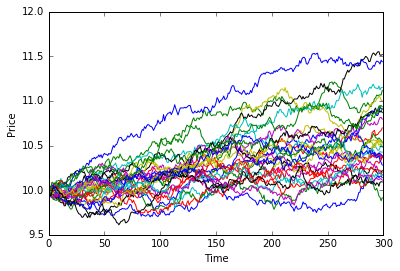

In [41]:
for run in range(30):
    plt.plot(random_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price");

Final price is spread out between 9.5€ (our portfolio has lost value) to almost 12€. The expectation (mean outcome) is a profit; this is due to the fact that the drift in our random walk (parameter mu) is positive.

Now let's run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation. This will take a little time to run, depending on the variable `runs`.

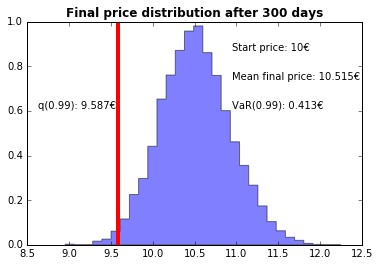

In [43]:
runs = 10000
simulations = numpy.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10.0)[days-1]
q = numpy.percentile(simulations, 1)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, u"Start price: 10€")
plt.figtext(0.6, 0.7, u"Mean final price: %.3f€" % simulations.mean())
plt.figtext(0.6, 0.6, u"VaR(0.99): %.3f€" % (10 - q,))
plt.figtext(0.15, 0.6, u"q(0.99): %.3f€" % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u"Final price distribution after {} days".format(days), weight='bold');

We have looked at the 1% empirical quantile of the final price distribution to estimate the Value at Risk, which is 0.427€ for a 10€ investment.

## Correlation between stocks

In [16]:
start = datetime.datetime(2005, 1, 1)
end   = datetime.datetime(2010, 1, 1)
CAC = DataReader("^FCHI", "yahoo", start, end)
DAX = DataReader("^GDAXI", "yahoo", start, end)
HSI = DataReader("^HSI", "yahoo", start, end)
AORD = DataReader("^AORD", "yahoo", start, end)

df = DataFrame({ 'CAC': CAC["Close"].pct_change(),
                 'DAX': DAX["Close"].pct_change(),
                 'HSI': HSI["Close"].pct_change(),
                 'AORD': AORD["Close"].pct_change() })
dfna = df.dropna()

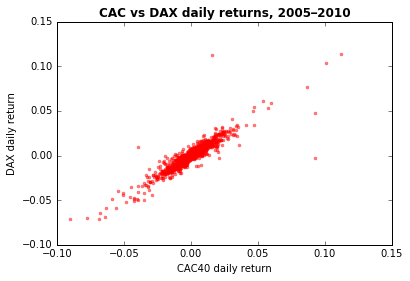

In [17]:
plt.plot(dfna["CAC"], dfna["DAX"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DAX daily return")
plt.title(u"CAC vs DAX daily returns, 2005–2010", weight='bold');

In [18]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DAX"])

(0.91762819023234377, 0.0)

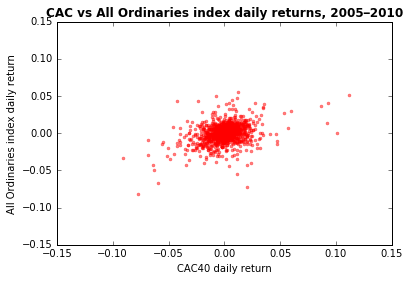

In [19]:
plt.plot(dfna["CAC"], dfna["AORD"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"All Ordinaries index daily return")
# ensure square aspect ratio
plt.axes().set_xlim(-0.15, 0.15)
plt.axes().set_ylim(-0.15, 0.15)
plt.title(u"CAC vs All Ordinaries index daily returns, 2005–2010", weight='bold');

In [20]:
scipy.stats.pearsonr(dfna["CAC"], dfna["AORD"])

(0.35595483023963886, 5.0844370128928888e-38)

CAC t fit: mean=0.00047807852049, scale=0.0089820020892, df=2.7555472507


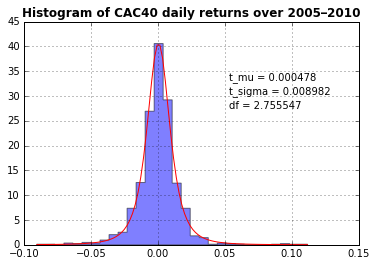

In [23]:
returns = dfna["CAC"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("CAC t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"t_mu = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, u"t_sigma = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of CAC40 daily returns over 2005–2010", weight='bold');

DAX t fit: mean=0.000847803008408, scale=0.00878082895409, df=2.71766905436


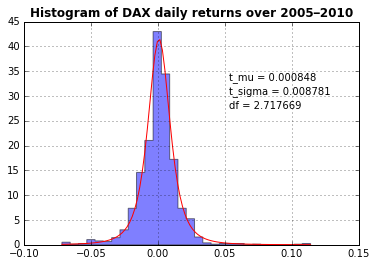

In [24]:
returns = dfna["DAX"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("DAX t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"t_mu = %3f" % tmean)
plt.figtext(0.6, 0.65, u"t_sigma = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of DAX daily returns over 2005–2010", weight='bold');

Let's simulate random joint stock returns from a joint distribution of fitted-CAC and fitted-DAX according to the distribution parameters estimated above, and plot the results. We need these simulated joint returns to do a Monte Carlo VaR analysis of a stock portfolio composed of CAC and DAX stock.

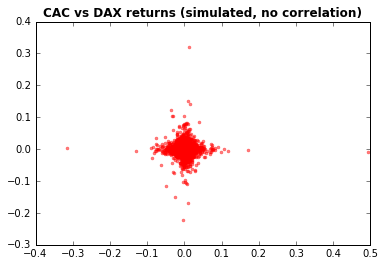

In [25]:
runs = 5000
fittedCAC = numpy.zeros(runs, float)
fittedDAX = numpy.zeros(runs, float)
for i in range(runs):
    fittedCAC[i] = scipy.stats.t.rvs(loc=0.000478137351981, scale=0.00898201242824, df=2.75557323986)
    fittedDAX[i] = scipy.stats.t.rvs(loc=0.000847802944791, scale=0.00878082895409, df=2.71766905436)
plt.plot(fittedCAC, fittedDAX, 'r.', alpha=0.5)
plt.title(u"CAC vs DAX returns (simulated, no correlation)", weight='bold');